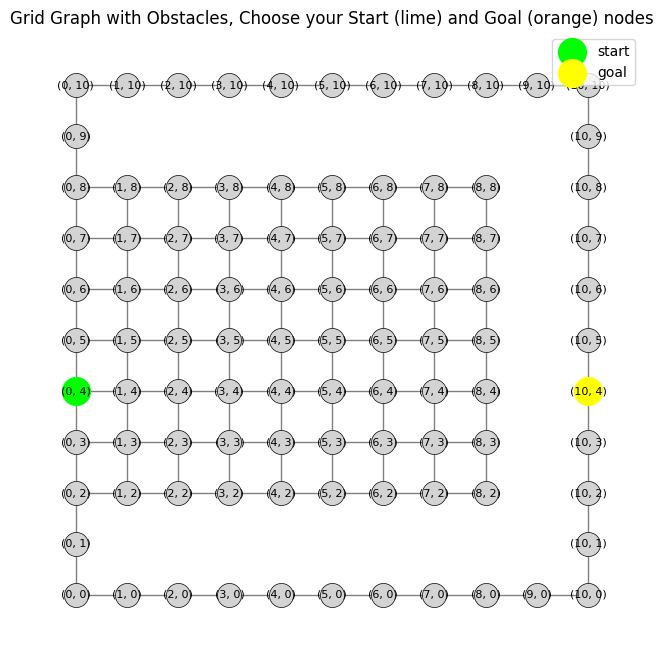

In [1]:
from create_graph import build_grid_graph, visualize_graph

'''0. Create Graph Data'''
G, mapping, inv_map, obstacles = build_grid_graph()

'''Choose start and goal'''
start = (0, 4)
goal = (10, 4)
visualize_graph(G, mapping, inv_map, start=start, goal=goal)

✅ The traditional A* can definitely find the shortest path, but it also explores a large number of nodes. If the graph is larger than this illustration, it will consume a significant amount of time.

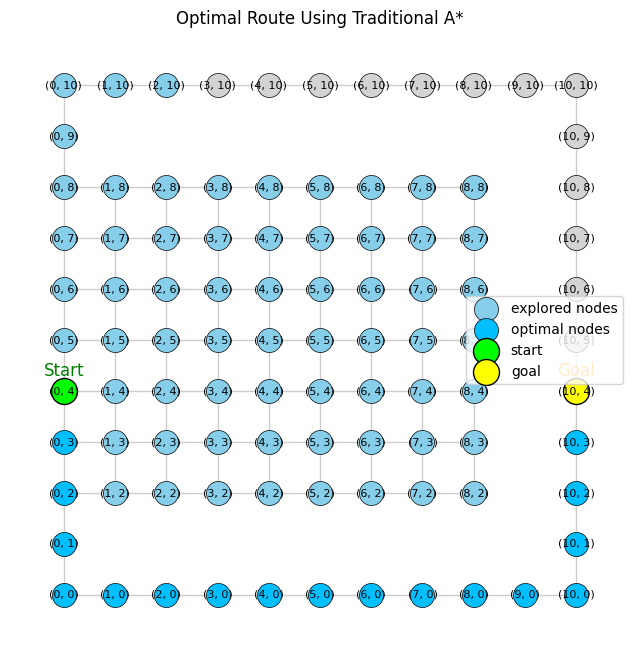

In [2]:
'''1. Benchmark Method: traditional A*'''
from astar import astar, visualize_astar

path, visited = astar(G, start, goal, obstacles)

pos = {coord: coord for coord in G.nodes()}
visualize_astar(G, pos, path, visited)

🔧Now the helper GNN comes into play:
- In this illustration, only 8 landmark nodes are selected. (🎈In practice, a well-chosen set of landmark nodes can significantly improve the generalization of a GNN. The selection of representative landmark nodes is beyond the scope of this notebook.)
- 🎈Another notable feature is that instead of iterating over all possible pairs, pairs are formed only when the two nodes are within a Manhattan distance of `DISTANCE_THRESHOLD_FOR_SELECTING_PAIRS = 10`.

In [10]:
'''Create Training Dataset'''
from create_data import generate_landmark_samples, get_edge_index

landmarks = [(0,2), (0,8), (8,8), (8,2), (10,10), (10,0), (10,5), (8,5)]

DISTANCE_THRESHOLD_FOR_SELECTING_PAIRS = 10
data_samples, valid_pairs = generate_landmark_samples(G, mapping, obstacles, landmarks,
                                                      distance_threshold=DISTANCE_THRESHOLD_FOR_SELECTING_PAIRS)

# Only 18 training pairs are created.
# Due to the undirected nature of the graph, this results in 18 × 2 directed pairs in the end.


Filtering landmark pairs by Manhattan distance (max 10):
  Including (0, 2) ↔ (0, 8) (d=6)
  Excluding (0, 2) ↔ (8, 8) (d=14 > 10)
  Including (0, 2) ↔ (8, 2) (d=8)
  Excluding (0, 2) ↔ (10, 10) (d=18 > 10)
  Excluding (0, 2) ↔ (10, 0) (d=12 > 10)
  Excluding (0, 2) ↔ (10, 5) (d=13 > 10)
  Excluding (0, 2) ↔ (8, 5) (d=11 > 10)
  Including (0, 8) ↔ (8, 8) (d=8)
  Excluding (0, 8) ↔ (8, 2) (d=14 > 10)
  Excluding (0, 8) ↔ (10, 10) (d=12 > 10)
  Excluding (0, 8) ↔ (10, 0) (d=18 > 10)
  Excluding (0, 8) ↔ (10, 5) (d=13 > 10)
  Excluding (0, 8) ↔ (8, 5) (d=11 > 10)
  Including (8, 8) ↔ (8, 2) (d=6)
  Including (8, 8) ↔ (10, 10) (d=4)
  Including (8, 8) ↔ (10, 0) (d=10)
  Including (8, 8) ↔ (10, 5) (d=5)
  Including (8, 8) ↔ (8, 5) (d=3)
  Including (8, 2) ↔ (10, 10) (d=10)
  Including (8, 2) ↔ (10, 0) (d=4)
  Including (8, 2) ↔ (10, 5) (d=5)
  Including (8, 2) ↔ (8, 5) (d=3)
  Including (10, 10) ↔ (10, 0) (d=10)
  Including (10, 10) ↔ (10, 5) (d=5)
  Including (10, 10) ↔ (8, 5) (d=7)
  Inc

🧪 In the rest of this notebook:
- ❶ Try using a type of GNN to test whether it can predict the distance from all nodes to the goal nodes.

- ❷ Then, integrate the trained GNN into A* to observe whether it helps reduce the number of explored nodes.

- According to GNN literature, using more layers allows each node to aggregate information from a wider neighborhood, effectively seeing farther. However, in real training scenarios, this often becomes impractical.

- Therefore, in this notebook, a small number of layers is used (`n_layers=6`). To compensate for the limited receptive field and promote consistency, a hinge loss is applied.

Epoch 0, Loss: 47.1027
Epoch 10, Loss: 27.4859
Epoch 20, Loss: 24.5605
Epoch 30, Loss: 20.7606
Epoch 40, Loss: 15.6591
Epoch 50, Loss: 12.1341
Epoch 60, Loss: 11.9092
Epoch 70, Loss: 9.6767
Epoch 80, Loss: 8.6688
Epoch 90, Loss: 7.9871
Epoch 100, Loss: 7.4104

=== Evaluation per Landmark Pair ===
From (0, 2) to (0, 8): pred=11.64, true=6, err=5.64
From (0, 8) to (0, 2): pred=10.36, true=6, err=4.36
From (0, 2) to (8, 2): pred=9.40, true=8, err=1.40
From (8, 2) to (0, 2): pred=7.79, true=8, err=0.21
From (0, 8) to (8, 8): pred=9.81, true=8, err=1.81
From (8, 8) to (0, 8): pred=8.07, true=8, err=0.07
From (8, 8) to (8, 2): pred=10.21, true=6, err=4.21
From (8, 2) to (8, 8): pred=10.38, true=6, err=4.38
From (8, 8) to (10, 10): pred=24.72, true=20, err=4.72
From (10, 10) to (8, 8): pred=23.46, true=20, err=3.46
From (8, 8) to (10, 0): pred=20.57, true=26, err=5.43
From (10, 0) to (8, 8): pred=15.65, true=26, err=10.35
From (8, 8) to (10, 5): pred=23.28, true=25, err=1.72
From (10, 5) to (

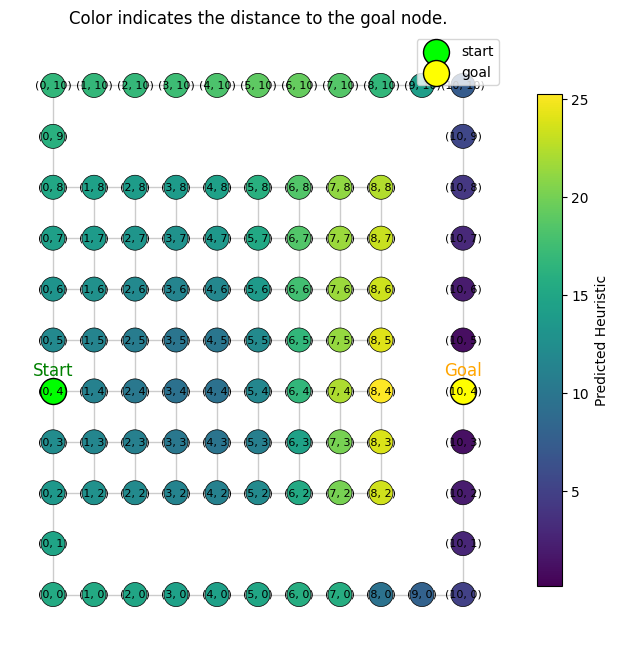

In [ ]:
'''1. SAGEConv'''
from graph_neural_network.sageconv import train_model
from graph_neural_network.utils import evaluate_model, get_heuristic, visualize_gnn

model = train_model(data_samples, lr=1e-3, epochs=101, lambda_consistency=1.0)

errors, true_dists, pred_dists = evaluate_model(model, valid_pairs, G, mapping, obstacles)

eidx = get_edge_index(G, mapping)
hval, hvec = get_heuristic(model, start, goal, G, mapping, eidx, obstacles)
pos = { n: n for n in G.nodes() }
visualize_gnn(G, pos, hvec, start, goal)

🧪 Now integrate the above trained GNN model as the heuristic function into A*.

⭐🎯Despite this minimal setup, the results are quite encouraging: the number of explored nodes is effectively reduced.

⭐🎯Note that only 8 of the 132 nodes are selected as landmarks, and not all possible pairs are included in the training set.

Path length: 18


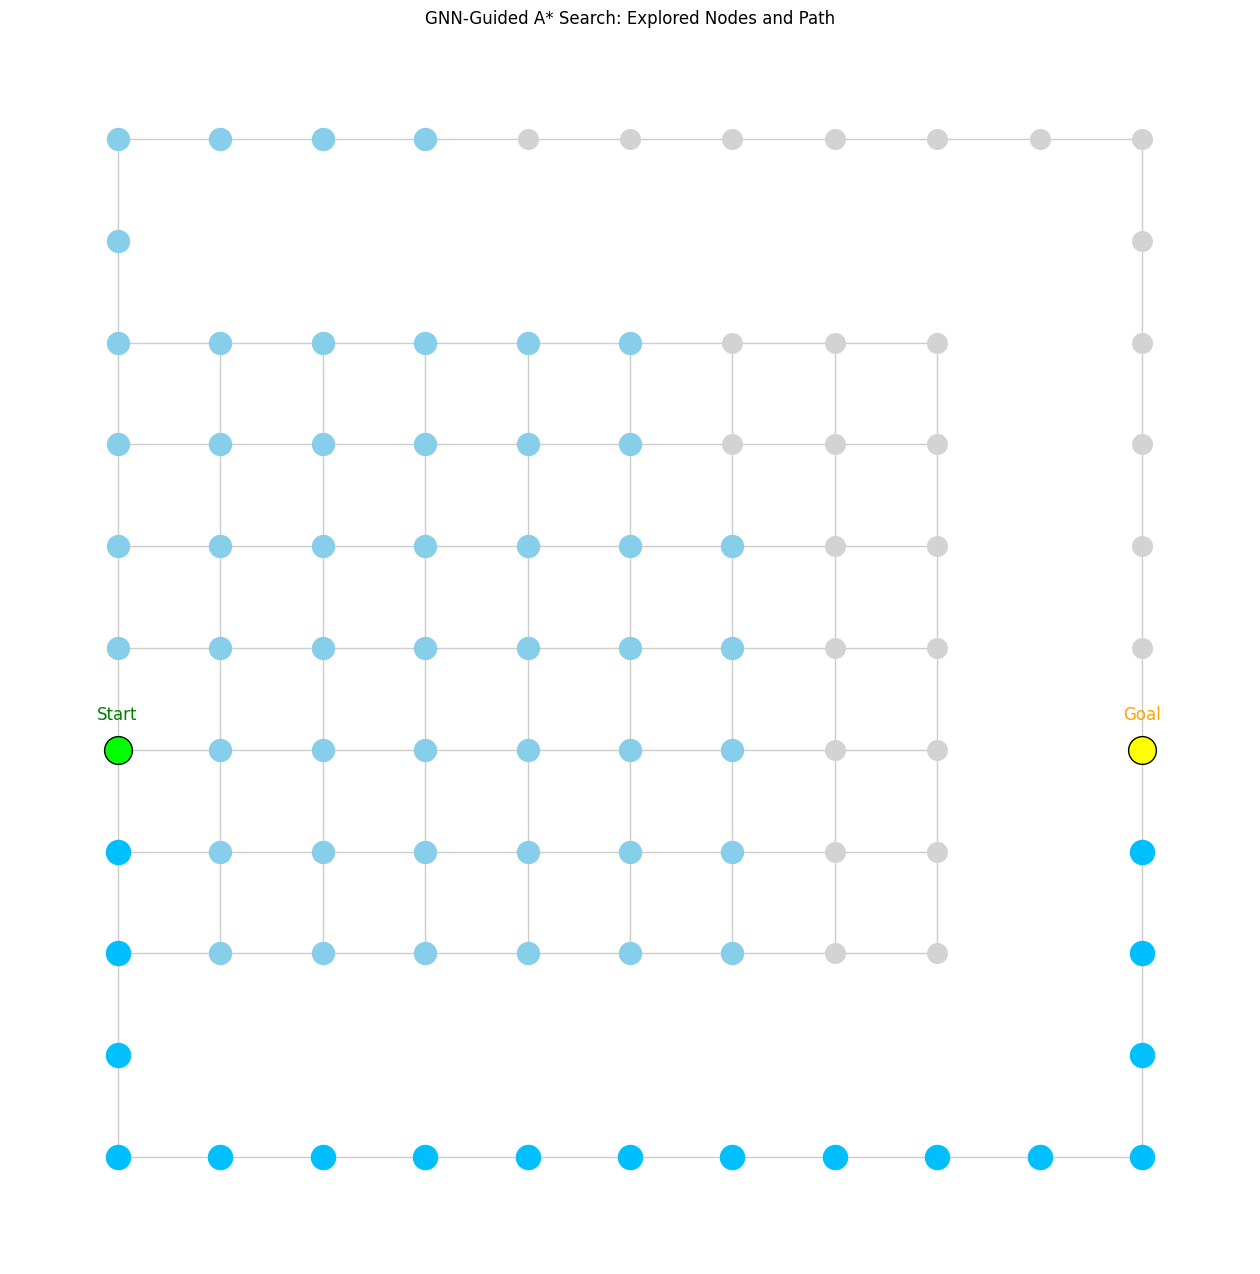

In [7]:
from gnn_guided_astar import a_star_with_gnn, visualize_astar_exploration

DIV = 11
path, visited = a_star_with_gnn(G, start, goal, model, mapping, get_edge_index(G, mapping), obstacles, DIV)

print(f"Path length: {len(path)-1}")
visualize_astar_exploration(G, path, visited, start, goal, obstacles)

🧪 Feel free to try other types of GNN below.

In [ ]:
# '''2. Plain GNN with skip connection'''
# from graph_neural_network.gnn import train_model
# from graph_neural_network.utils import evaluate_model, get_heuristic, visualize_gnn

# model = train_model(data_samples, lr=1e-3, epochs=11, lambda_consistency=1.0)

# errors, true_dists, pred_dists = evaluate_model(model, valid_pairs, G, mapping, obstacles)

# eidx = get_edge_index(G, mapping)
# hval, hvec = get_heuristic(model, start, goal, G, mapping, eidx, obstacles)
# pos = { n: n for n in G.nodes() }
# visualize_gnn(G, pos, hvec, start, goal)

In [ ]:
# path, visited = gnn_guided_astar(G, start, goal, model, mapping, eidx, obstacles)

# print(f"Path length: {len(path)-1}")
# visualize_astar_exploration(G, path, visited, start, goal, obstacles)

In [ ]:
# '''3. GCN'''
# from gcn import train_model
# from utils import evaluate_model, get_heuristic, visualize_gnn

# model = train_model(data_samples, lr=1e-3, epochs=101, lambda_consistency=1.0)

# errors, true_dists, pred_dists = evaluate_model(model, valid_pairs, G, mapping, obstacles)

# eidx = get_edge_index(G, mapping)
# hval, hvec = get_heuristic(model, start, goal, G, mapping, eidx, obstacles)
# pos = { n: n for n in G.nodes() }
# visualize_gnn(G, pos, hvec, start, goal)

In [9]:
# path, visited = gnn_guided_astar(G, start, goal, model, mapping, eidx, obstacles)

# print(f"Path length: {len(path)-1}")
# visualize_astar_exploration(G, path, visited, start, goal, obstacles)